# Part 1 ‐ Exploratory data analysis

In [43]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
with open('logins.json', 'r') as file:
    login_data = json.load(file)

In [45]:
login_df = pd.DataFrame(login_data, columns=['login_time'])
login_df['login_time'] = pd.to_datetime(login_df['login_time'])

In [46]:
login_df.set_index('login_time', inplace=True)
login_counts_15min = login_df.resample('15min').size()

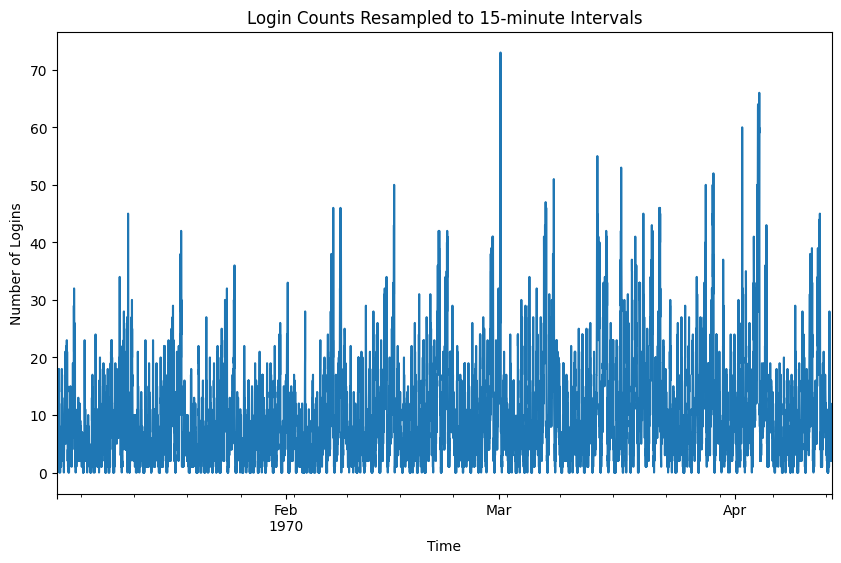

In [47]:
plt.figure(figsize = (10, 6))
login_counts_15min.plot()
plt.title('Login Counts Resampled to 15-minute Intervals')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.show()

# Part 2 ‐ Experiment and metrics design

### Question 1

The key measure of success for this experiment would be the increase in the number of unique drivers who serve both Gotham and Metropolis, as compared to drivers serving only one city. This metric is appropriate because:  

> It directly reflects the goal of the experiment: to encourage driver partners to operate in both cities.  
> The experiment aims to reduce the toll as a barrier, and the success can be measured by how many drivers respond to this incentive.  
> It's measurable and can be tracked over time to assess the behavioral change of drivers.  

### Question 2

Experiment Type: A/B Test (Randomized Control Trial)  

a) Implementation:  

Time Period: Conduct the experiment for a period of at least 2-4 weeks, ideally covering both weekdays and weekends to account for varying activity patterns.

Randomization: Randomly split the drivers into two groups:

Group A (Control): No toll reimbursement (current state).
Group B (Treatment): Toll reimbursement for all trips between Gotham and Metropolis.
Data Collection:

Baseline Data: Before the experiment starts, collect baseline data on driver patterns: the number of drivers operating in one or both cities, total trips, and revenue.
During the Experiment: Track the number of drivers serving both cities, total rides, revenue per driver, and frequency of trips between the cities in both groups.
Communication: Ensure that drivers in Group B are aware of the toll reimbursement incentive through clear messaging, while drivers in Group A operate under current conditions.

b) Statistical Tests to Verify the Significance:  

Null Hypothesis (H0): Toll reimbursement has no effect on the number of drivers serving both cities.  
Alternative Hypothesis (H1): Toll reimbursement increases the number of drivers serving both cities.  

Two-Proportion Z-Test: Use this to test whether the proportion of drivers serving both cities in the treatment group (Group B) is significantly higher than the control group (Group A).  

c) Interpretation of Results and Recommendations:  

If the proportion of drivers serving both cities is significantly higher in Group B (toll reimbursement), and their average number of cross-city trips has increased, this would suggest that the toll reimbursement is effective in encouraging drivers to serve both cities.

If the test results show no significant difference between the control and treatment groups, this would indicate that the toll reimbursement does not strongly affect driver behavior, and other barriers might need to be addressed.

# Part 3 ‐ Predictive modeling

### EDA

In [48]:
import numpy as np

In [49]:
data = pd.read_json('ultimate_data_challenge.json')

In [50]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


In [51]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [52]:
data["avg_rating_of_driver"] = data["avg_rating_of_driver"].fillna(np.mean(data["avg_rating_of_driver"]))

In [53]:
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])

In [54]:
last_trip_cutoff = data['last_trip_date'].max() - pd.Timedelta(days=30)
data['retained'] = data['last_trip_date'] >= last_trip_cutoff

In [55]:
retention_rate = data['retained'].mean()
print(f"Retention Rate: {retention_rate:.2%}")

Retention Rate: 37.61%


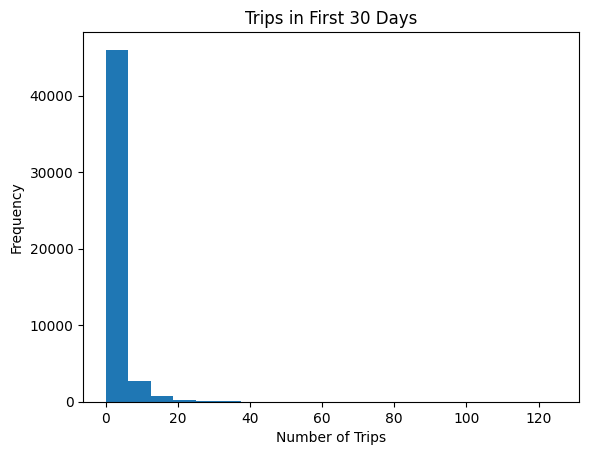

In [56]:
plt.hist(data['trips_in_first_30_days'], bins=20)
plt.title('Trips in First 30 Days')
plt.xlabel('Number of Trips')
plt.ylabel('Frequency')
plt.show()

### Model

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [58]:
features = ['avg_rating_of_driver', 'avg_surge', 'trips_in_first_30_days', 'ultimate_black_user']
X = data[features]
y = data['retained']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 19)

In [60]:
clf = RandomForestClassifier(random_state = 19)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=19)

In [61]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

In [62]:
print(f"Accuracy: {accuracy:.2%}")
print(f"AUC-ROC: {roc_auc:.2f}")

Accuracy: 72.14%
AUC-ROC: 0.67


In [63]:
clf.feature_importances_

array([0.24245967, 0.42571767, 0.23718213, 0.09464053])

In [64]:
features

['avg_rating_of_driver',
 'avg_surge',
 'trips_in_first_30_days',
 'ultimate_black_user']

### Conclusion

As avg_surge is the most important feature:  

Surge pricing sensitivity: Users who experience higher average surge rates may be less likely to stay engaged if they feel they are frequently paying more due to surge pricing. Alternatively, users who continue using the service despite higher surge rates may be more loyal or have a higher tolerance for price fluctuations.  

Premium or urgent trips: Users facing high surge prices may be more likely to use the service when they are in urgent need (e.g., at peak times, during bad weather, or in areas with limited transportation options). If this is true, surge pricing could indicate that some users are less price-sensitive, and they may rely on the service for critical rides.  

Business Recommendations:  

Surge-Based Campaigns: Create custom campaigns that reward users who frequently ride during surge times. For example, after experiencing 3 surge-priced rides, users could get the next ride at a discount.

Price Sensitivity Segmentation: Segment users into price-sensitive and non-price-sensitive groups based on their surge pricing history. Tailor retention strategies accordingly. Price-sensitive users may need more offers and rewards, while non-price-sensitive users can be targeted for premium services.